# 01 - EDA e Inferencia Inicial

Este notebook cubre la **Fase 4** del proyecto:
- Carga y validacion de datos procesados
- KPIs base
- Cruces clave
- Pruebas estadisticas (Chi-cuadrada, Spearman)
- Modelo logístico exploratorio


## Disclaimer
> Este dataset fue levantado en **2021**, durante el punto mas critico de la pandemia por COVID-19, con una **muestra pequena y no probabilistica**.
> Este proyecto reutiliza esa base de una actividad academica para demostrar un flujo profesional de Data Analyst (limpieza, analisis, inferencia y dashboard).


In [1]:
from pathlib import Path
import subprocess
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
sns.set_theme(style='whitegrid')


In [2]:
project_root = Path.cwd()
if not (project_root / 'data').exists() and (project_root.parent / 'data').exists():
    project_root = project_root.parent

processed_csv = project_root / 'data/processed/survey_analytics.csv'

if not processed_csv.exists():
    print('No existe data/processed/survey_analytics.csv. Ejecutando limpieza...')
    cmd = ['python3', str(project_root / 'src/data/clean_survey.py')]
    result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(project_root))
    print(result.stdout)
    if result.returncode != 0:
        raise RuntimeError(f'Error en limpieza: {result.stderr}')

if not processed_csv.exists():
    raise FileNotFoundError('No se pudo generar data/processed/survey_analytics.csv')

df = pd.read_csv(processed_csv)
print('Shape:', df.shape)
df.head()


Shape: (178, 24)


,timestamp_raw,gender,q1_current_state,q2_emotional_state,q3_impact,q4_problems,q5_help_seek,q6_pre_pandemic_state,q7_learned_new_skill,q8_learned_text,q9_future_normality,q10_stress,q11_optimism,q12_control,q13_protocols,q14_anxiety,q15_wellbeing_final,timestamp,q10_stress_score,q11_optimism_score,q12_control_score,q13_protocols_score,q14_anxiety_score,q15_wellbeing_score
0,2021-04-29 22:00:07.041,Hombre,Ni bien ni mal.,Regular,Negativa,Prefiero no decir.,NaN,Bien,No,NaN,Si,Casi siempre,De vez en cuando,Casi nunca,De vez en cuando,Casi nunca,Tal vez,2021-04-29 22:00:07.041,3,2.0,1.0,2.0,1.0,1.0
1,2021-04-30 03:10:30.453,Hombre,Bien,Regular,Negativa,No,NaN,Normal,Si,Idiomas,Si,Nunca,Siempre,De vez en cuando,Siempre,Casi nunca,Si,2021-04-30 03:10:30.453,0,4.0,2.0,4.0,1.0,2.0
2,2021-04-30 04:31:08.021,Hombre,Bien,Muy bien,Positiva,Si,Si,Mal,Si,Aleman y portugues,Si,Casi nunca,Casi siempre,Casi siempre,De vez en cuando,De vez en cuando,Tal vez,2021-04-30 04:31:08.021,1,3.0,3.0,2.0,2.0,1.0
3,2021-04-30 07:39:43.916,Hombre,Bien,Regular,Negativa,Si,No,Bien,No,NaN,Tal vez,De vez en cuando,De vez en cuando,De vez en cuando,Casi siempre,Casi nunca,Si,2021-04-30 07:39:43.916,2,2.0,2.0,3.0,1.0,2.0
4,2021-04-30 07:45:46.235,Hombre,Bien,Excelente,Positiva,No,No,No tan mal,Si,Lit aprendí a hacer todo lo que no me atrevía ...,Tal vez,Nunca,De vez en cuando,Siempre,Siempre,Nunca,Si,2021-04-30 07:45:46.235,0,2.0,4.0,4.0,0.0,2.0


In [3]:
quality = pd.DataFrame({
    'dtype': df.dtypes.astype(str),
    'nulls': df.isna().sum(),
    'null_pct': (df.isna().mean() * 100).round(2),
    'n_unique': df.nunique(dropna=True)
}).sort_values('null_pct', ascending=False)

quality


,dtype,nulls,null_pct,n_unique
q8_learned_text,object,76,42.70,95
q5_help_seek,object,30,16.85,3
q13_protocols,object,6,3.37,5
q13_protocols_score,float64,6,3.37,5
q15_wellbeing_score,float64,4,2.25,3
q12_control,object,3,1.69,5
q12_control_score,float64,3,1.69,5
q14_anxiety_score,float64,2,1.12,5
q14_anxiety,object,2,1.12,5
q11_optimism_score,float64,1,0.56,5


In [4]:
def pct(series, value):
    valid = series.dropna()
    if len(valid) == 0:
        return np.nan
    return round((valid == value).mean() * 100, 2)

kpis = {
    'n_respuestas': len(df),
    'pct_impacto_negativo': pct(df.get('q3_impact', pd.Series(dtype='object')), 'Negativa'),
    'pct_impacto_positivo': pct(df.get('q3_impact', pd.Series(dtype='object')), 'Positiva'),
    'pct_reporta_problemas_si': pct(df.get('q4_problems', pd.Series(dtype='object')), 'Si'),
    'pct_bienestar_final_si': pct(df.get('q15_wellbeing_final', pd.Series(dtype='object')), 'Si'),
    'pct_bienestar_final_no_talvez': round(
        df.get('q15_wellbeing_final', pd.Series(dtype='object')).isin(['No', 'Tal vez']).mean() * 100, 2
    ) if 'q15_wellbeing_final' in df.columns else np.nan
}

kpi_df = pd.DataFrame([kpis]).T.reset_index()
kpi_df.columns = ['kpi', 'value']
kpi_df


,kpi,value
0,n_respuestas,178.00
1,pct_impacto_negativo,51.98
2,pct_impacto_positivo,48.02
3,pct_reporta_problemas_si,67.23
4,pct_bienestar_final_si,56.74
5,pct_bienestar_final_no_talvez,41.01


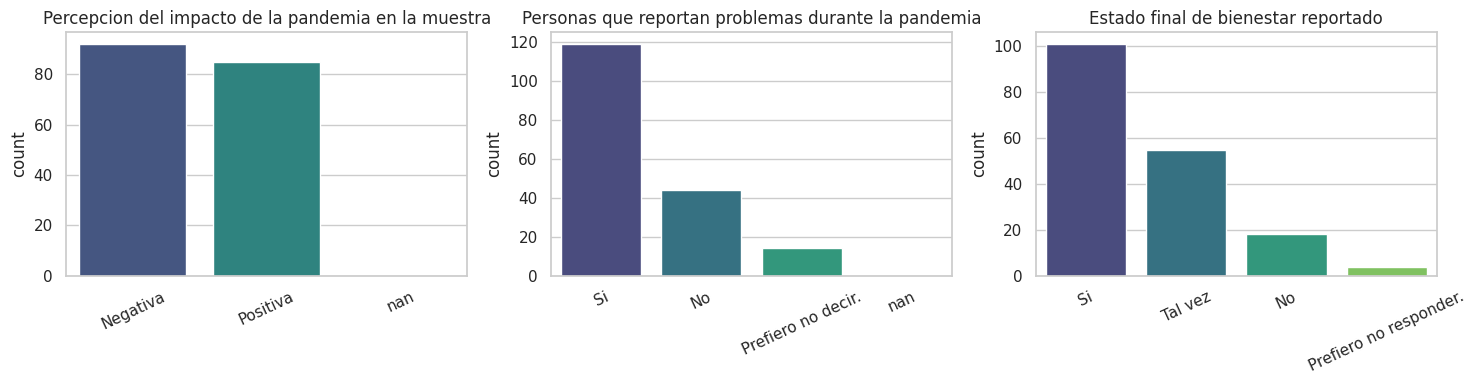

In [5]:
plot_cols = ['q3_impact', 'q4_problems', 'q15_wellbeing_final']
existing = [c for c in plot_cols if c in df.columns]

fig, axes = plt.subplots(1, len(existing), figsize=(5 * len(existing), 4))
if len(existing) == 1:
    axes = [axes]

for ax, col in zip(axes, existing):
    order = df[col].value_counts(dropna=False).index
    sns.countplot(data=df, x=col, order=order, ax=ax, palette='viridis')
    title_map = {
        'q3_impact': 'Percepcion del impacto de la pandemia en la muestra',
        'q4_problems': 'Personas que reportan problemas durante la pandemia',
        'q15_wellbeing_final': 'Estado final de bienestar reportado',
    }
    ax.set_title(title_map.get(col, col))
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()


q15_wellbeing_final,No,Prefiero no responder.,Si,Tal vez,All
gender,,,,,
Hombre,6,0,54,32,92
Mujer,12,3,47,23,85
Otro,0,1,0,0,1
All,18,4,101,55,178


q15_wellbeing_final,No,Prefiero no responder.,Si,Tal vez
gender,,,,
Hombre,0.065,0.000,0.587,0.348
Mujer,0.141,0.035,0.553,0.271
Otro,0.000,1.000,0.000,0.000


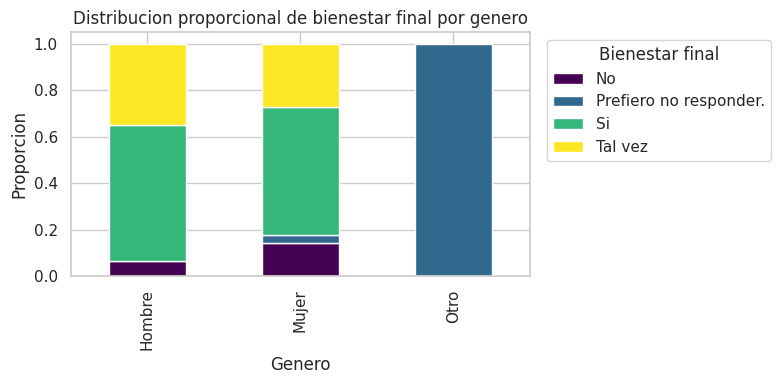

In [6]:
if {'gender', 'q15_wellbeing_final'}.issubset(df.columns):
    ct = pd.crosstab(df['gender'], df['q15_wellbeing_final'], margins=True)
    ct_pct = pd.crosstab(df['gender'], df['q15_wellbeing_final'], normalize='index').round(3)
    display(ct)
    display(ct_pct)

    ct_plot = pd.crosstab(df['gender'], df['q15_wellbeing_final'], normalize='index')
    ct_plot.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='viridis')
    plt.title('Distribucion proporcional de bienestar final por genero')
    plt.ylabel('Proporcion')
    plt.xlabel('Genero')
    plt.legend(title='Bienestar final', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('No se encontraron columnas gender y q15_wellbeing_final')


In [7]:
def chi_square_test(data, col_a, col_b):
    if not {col_a, col_b}.issubset(data.columns):
        return None
    subset = data[[col_a, col_b]].dropna()
    if subset.empty:
        return None
    table = pd.crosstab(subset[col_a], subset[col_b])
    if table.shape[0] < 2 or table.shape[1] < 2:
        return None
    chi2, p_value, dof, _ = chi2_contingency(table)
    return {'col_a': col_a, 'col_b': col_b, 'chi2': chi2, 'p_value': p_value, 'dof': dof, 'n': len(subset)}

tests = [
    chi_square_test(df, 'q3_impact', 'q15_wellbeing_final'),
    chi_square_test(df, 'q4_problems', 'q15_wellbeing_final'),
]

if 'q14_anxiety_score' in df.columns:
    temp = df.copy()
    temp['anxiety_high'] = np.where(temp['q14_anxiety_score'] >= 3, 'Alta', 'No alta')
    tests.append(chi_square_test(temp, 'q4_problems', 'anxiety_high'))

chi_results = pd.DataFrame([t for t in tests if t is not None]).sort_values('p_value')
chi_results


,col_a,col_b,chi2,p_value,dof,n
1,q4_problems,q15_wellbeing_final,30.417424,0.000033,6,177
2,q4_problems,anxiety_high,6.732661,0.034516,2,177
0,q3_impact,q15_wellbeing_final,4.178588,0.242814,3,177


,q10_stress_score,q11_optimism_score,q12_control_score,q13_protocols_score,q14_anxiety_score,q15_wellbeing_score
q10_stress_score,1.000000,-0.170949,-0.224941,0.047740,0.389091,-0.377696
q11_optimism_score,-0.170949,1.000000,0.520396,0.376355,-0.219206,0.338849
q12_control_score,-0.224941,0.520396,1.000000,0.288997,-0.163505,0.204687
q13_protocols_score,0.047740,0.376355,0.288997,1.000000,0.074921,0.003775
q14_anxiety_score,0.389091,-0.219206,-0.163505,0.074921,1.000000,-0.463323
q15_wellbeing_score,-0.377696,0.338849,0.204687,0.003775,-0.463323,1.000000


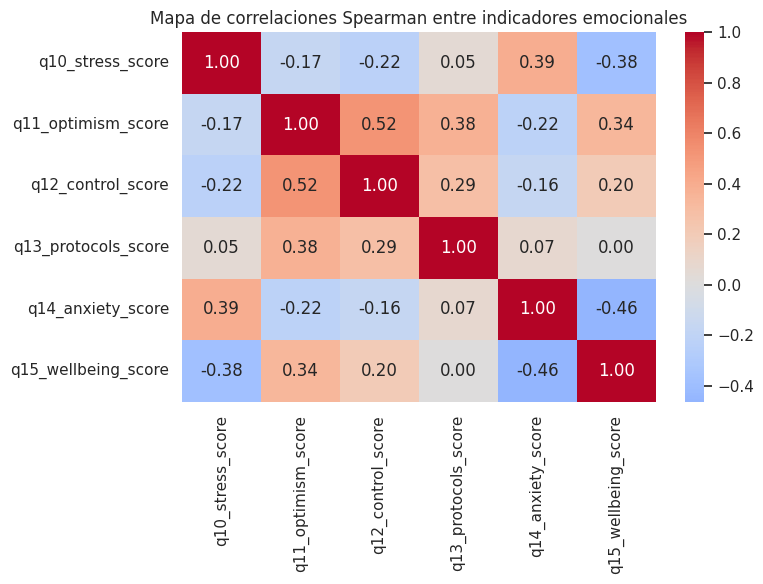

In [8]:
score_cols = [
    'q10_stress_score',
    'q11_optimism_score',
    'q12_control_score',
    'q13_protocols_score',
    'q14_anxiety_score',
    'q15_wellbeing_score'
]
score_cols = [c for c in score_cols if c in df.columns]

if len(score_cols) >= 2:
    corr = df[score_cols].corr(method='spearman')
    display(corr)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Mapa de correlaciones Spearman entre indicadores emocionales')
    plt.tight_layout()
    plt.show()

    pairs = []
    for i, a in enumerate(score_cols):
        for b in score_cols[i + 1:]:
            subset = df[[a, b]].dropna()
            if len(subset) >= 10:
                rho, p = spearmanr(subset[a], subset[b])
                pairs.append({'a': a, 'b': b, 'rho': rho, 'p_value': p, 'n': len(subset)})

    spearman_pairs = pd.DataFrame(pairs).sort_values('p_value')
    spearman_pairs.head(10)
else:
    print('No hay suficientes columnas de score para Spearman')


In [9]:
required = [
    'q15_wellbeing_final',
    'q10_stress_score',
    'q11_optimism_score',
    'q12_control_score',
    'q13_protocols_score',
    'q14_anxiety_score'
]

if set(required).issubset(df.columns):
    model_df = df.copy()
    model_df['target_low_wellbeing'] = model_df['q15_wellbeing_final'].isin(['No', 'Tal vez']).astype(int)

    feature_cols = [
        'q10_stress_score',
        'q11_optimism_score',
        'q12_control_score',
        'q13_protocols_score',
        'q14_anxiety_score',
        'q3_impact',
        'q4_problems',
        'gender'
    ]
    feature_cols = [c for c in feature_cols if c in model_df.columns]

    X = model_df[feature_cols]
    y = model_df['target_low_wellbeing']

    numeric_features = [c for c in feature_cols if str(model_df[c].dtype) != 'object']
    categorical_features = [c for c in feature_cols if c not in numeric_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features),
        ]
    )

    model = Pipeline(
        steps=[
            ('prep', preprocessor),
            ('clf', LogisticRegression(max_iter=200, random_state=42))
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('Matriz de confusion:')
    print(confusion_matrix(y_test, y_pred))
    print('\nReporte de clasificacion:')
    print(classification_report(y_test, y_pred, digits=3))
else:
    print('No hay columnas suficientes para el modelo logístico exploratorio.')


Matriz de confusion:
[[17 10]
 [ 2 16]]

Reporte de clasificacion:
              precision    recall  f1-score   support

           0      0.895     0.630     0.739        27
           1      0.615     0.889     0.727        18

    accuracy                          0.733        45
   macro avg      0.755     0.759     0.733        45
weighted avg      0.783     0.733     0.734        45



In [10]:
from IPython.display import Markdown, display

summary_lines = []
summary_lines.append('## Conclusiones Automaticas del Notebook')
summary_lines.append('')

if 'kpi_df' in globals():
    kpi_map = dict(zip(kpi_df['kpi'], kpi_df['value']))
    summary_lines.append(f"- Respuestas analizadas: **{int(kpi_map.get('n_respuestas', 0))}**")
    summary_lines.append(f"- % impacto negativo: **{kpi_map.get('pct_impacto_negativo', 'NA')}%**")
    summary_lines.append(f"- % reporta problemas: **{kpi_map.get('pct_reporta_problemas_si', 'NA')}%**")
    summary_lines.append(f"- % bienestar final No/Tal vez: **{kpi_map.get('pct_bienestar_final_no_talvez', 'NA')}%**")

if 'chi_results' in globals() and not chi_results.empty:
    sig = chi_results[chi_results['p_value'] < 0.05]
    if len(sig) > 0:
        summary_lines.append('')
        summary_lines.append('- Asociaciones significativas (alpha=0.05):')
        for _, row in sig.iterrows():
            summary_lines.append(f"  - `{row['col_a']} vs {row['col_b']}` (p={row['p_value']:.6f})")
    else:
        summary_lines.append('')
        summary_lines.append('- No se detectaron asociaciones significativas en las pruebas chi-cuadrada ejecutadas.')

if 'spearman_pairs' in globals() and not spearman_pairs.empty:
    top = spearman_pairs.iloc[0]
    summary_lines.append('')
    summary_lines.append(
        f"- Relacion ordinal mas fuerte detectada: `{top['a']} vs {top['b']}` "
        f"(rho={top['rho']:.3f}, p={top['p_value']:.2e})."
    )

summary_lines.append('')
summary_lines.append('**Nota metodologica:** resultados asociativos, no causales; base 2021 con muestra acotada.')

display(Markdown('\n'.join(summary_lines)))



## Conclusiones Automaticas del Notebook

- Respuestas analizadas: **178**
- % impacto negativo: **51.98%**
- % reporta problemas: **67.23%**
- % bienestar final No/Tal vez: **41.01%**

- Asociaciones significativas (alpha=0.05):
  - `q4_problems vs q15_wellbeing_final` (p=0.000033)
  - `q4_problems vs anxiety_high` (p=0.034516)

- Relacion ordinal mas fuerte detectada: `q11_optimism_score vs q12_control_score` (rho=0.520, p=1.57e-13).

**Nota metodologica:** resultados asociativos, no causales; base 2021 con muestra acotada.